# Face Generation
Pytorch implementation of **generative adversarial network (GAN)** for generating new images of faces. 

The model uses **DCGAN architecture** proposed in [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434), it is trained on [CelebFaces Attributes (CelebA) Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). 

To stabilize training, labels of real images are **smoothed** ([Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498)) and random **Gaussian noise** is added to all images ([Amortised MAP Inference for Image Super-resolution](https://arxiv.org/abs/1610.04490))

This is the fifth assigment for [Udacity Deep Learning Nanodegree](https://eu.udacity.com/course/deep-learning-nanodegree--nd101).

### Import Dependencies

In [0]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import time
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print('CUDA is available! Training on GPU.')
else:
    print('CUDA is not available. Training on CPU.')    

CUDA is available! Training on GPU.


## Load the Data


In [0]:
def load_data(batch_size, image_size = 32, 
              data_dir = 'processed_celeba_small/'):
    '''
    Loads and batches data and returns a dataloader.
    
    :param batch_size: a number of images in a batch
    :param image_size: target size of the images
    :param data_dir: path to the images
    :return: a dataloader with the images
    '''
    
    # Resize images and convert to tensors
    data_transform = transforms.Compose([transforms.Resize(image_size),
                                         transforms.ToTensor()])
    # Load and batch the images
    dataset = datasets.ImageFolder(data_dir, transform = data_transform)
    dataloader = torch.utils.data.DataLoader(dataset, shuffle = True, 
                                             batch_size = batch_size)
    
    return dataloader

### Visualize the Data

In [0]:
def to_numpy(image):
    '''
    Converts an image to numpy array.
    
    :param image: image as a tensor
    :return: an image as a numpy array
    '''
    
    image = image.numpy().transpose((1, 2, 0)) 
    return image

In [0]:
def display_images(images, num_images, rows = 2):
    '''
    Display images.
    
    :param images: images to display
    :param num_images: a number of images to display
    :param rows: a number of rows
    '''
    
    fig = plt.figure(figsize=(num_images * 2 / rows, rows * 2))
    for i in range(num_images):
        ax = fig.add_subplot(2, num_images / rows, i+1, xticks=[], yticks=[])
        ax.imshow(to_numpy(images[i]))

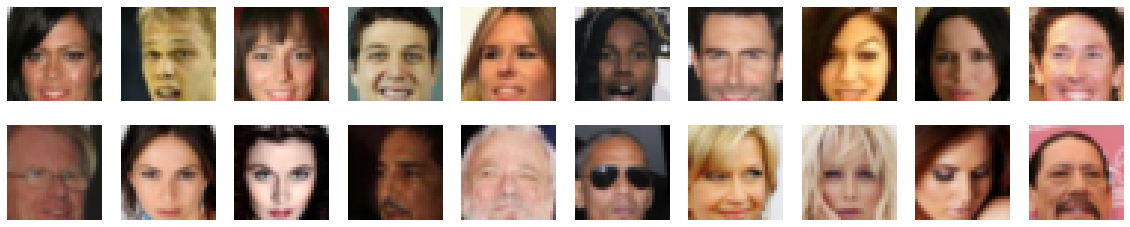

In [0]:
# Create loader
num_images = 20
loader = load_data(num_images)

# Get a batch of images and display them
images, _ = next(iter(loader))
display_images(images, num_images)

### Image Preprocessing
Here we define two helper functions for preprocessing images. The first one **scales an image** into range [-1, 1], this will allow us to use `tanh` activation function in a generator, the other **adds noise** to an image, making training more stable.

In [0]:
def scale(image, value_range = (-1, 1)):
    '''
    Scales an image into a range.
    
    :param image: image to scale
    :param value_range: range of values of output image
    :return: scaled image
    '''
    
    return image * (value_range[1] - value_range[0]) + value_range[0]

In [0]:
def add_noise(images, sigma):
    '''
    Adds random noise to images
    
    :param images: images to add noise to
    :param sigma: standard deviation of noise
    :return: images with noise
    '''
    
    noise = torch.tensor(np.random.normal(0, sigma, images.shape))
    noise = noise.view(images.shape).float()
    if train_on_gpu:
        noise = noise.cuda()
    return images + noise

## Define the Model
The model consists of a **discriminator** trying to **distinguish real and fake** (generated) images and a **generator** generating **new images** based on a random latent vector. Its goal is to **deceive the discriminator** into considering fake images real.

### Discriminator
The discriminator follows the DCGAN architecture, there are **4 blocks** containing **convolutional, batch norm and leaky relu** layers and a **final linear layer** for classification of images. The first layers doesn't use batch norm layer.

In [0]:
def conv_block(in_channels, out_channels, kernel = 4, stride = 2, padding = 1,
               batch_norm = True, relu_neg_slope = 0.2):
    '''
    Creates and returns a sequential block of layers - convolutional, batch norm
    (optional) and leaky relu.
    
    :param in_channels: a number of input channels
    :param out_channels: a number of output channels
    :param kernel: size of the convolutional kernel
    :param stride: stride of the convolutional layer
    :param padding: padding of the convolutional layer
    :param batch_norm: bool, if False, don't include batch norm layer
    :param relu_neg_slope: negative slope of leaky relu
    :return: sequential block of Conv2d, BatchNorm2d and LeakyReLU layers
    '''
    
    layers = []
    # Convolutional layer
    layers.append(nn.Conv2d(in_channels, out_channels, kernel, stride, padding, 
                            bias = False))
    
    # Batch norm
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    # Activation
    layers.append(nn.LeakyReLU(relu_neg_slope))
    
    return nn.Sequential(*layers)

In [0]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim):
        '''
        Initialize layers of the discriminator
        
        :param conv_dim: a number of output channels of the first convolutional
            layer
        '''
        
        super().__init__()
        
        self.conv_block1 = conv_block(3, conv_dim, batch_norm = False)
        self.conv_block2 = conv_block(conv_dim, conv_dim * 2)
        self.conv_block3 = conv_block(conv_dim * 2, conv_dim * 4)
        self.conv_block4 = conv_block(conv_dim * 4, conv_dim * 8)
        self.linear = nn.Linear(conv_dim * 8 * 2 * 2, 1)
        
    def forward(self, x):
        '''
        Perform forward pass through the discriminator
        
        :param x: input images to the discriminator
        :return: probability of images being real (vs. fake)
        '''
       
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        
        x = x.view(x.shape[0], -1)
        x = self.linear(x)
        
        return x

### Generator
Similarly, the generator consists of an initial **linear layer** followed by 4 blocks but instead of convolutional layers there are **transposed convolutional layers**. The final block doesn't contain batch norm layer and uses **tanh activation** function. It transforms an input random latent vector into a 3-color-channel output image.

In [0]:
def deconv_block(in_channels, out_channels, kernel = 4, stride = 2, padding = 1,
               batch_norm = True, use_tanh = False, relu_neg_slope = 0.2):
    '''
    Creates and returns a sequential block of layers - transposed convolutional, 
    batch norm (optional) and leaky relu or tanh.
    
    :param in_channels: a number of input channels
    :param out_channels: a number of output channels
    :param kernel: size of the transposed convolutional kernel
    :param stride: stride of the transposed convolutional layer
    :param padding: padding of the transposed convolutional layer
    :param batch_norm: bool, if False, don't include batch norm layer
    :param use_tanh: bool, if True, use tanh activation instead of leaky relu
    :param relu_neg_slope: negative slope of leaky relu
    :return: sequential block of ConvTranspose2d, BatchNorm2d (optional) and 
        LeakyReLU layers
    '''
    
    layers = []
    # Transposed convolutional layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel, stride, 
                                     padding, bias = False))
    
    # Batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    # Activation
    if use_tanh:
        layers.append(nn.Tanh())
    else:
        layers.append(nn.LeakyReLU(relu_neg_slope))
    
    return nn.Sequential(*layers)

In [0]:
class Generator(nn.Module):
    def __init__(self, z_size, conv_dim):
        '''
        Initialize layers of the generator
        
        :param z_size: size of a latent vector
        :param conv_dim: a number of output channels of the first convolutional
            layer
        '''
        
        super().__init__()
        
        self.linear = nn.Linear(z_size, conv_dim * 8 * 2 * 2)
        
        self.deconv_block1 = deconv_block(conv_dim * 8, conv_dim * 4)
        self.deconv_block2 = deconv_block(conv_dim * 4, conv_dim * 2)
        self.deconv_block3 = deconv_block(conv_dim * 2, conv_dim)
        self.deconv_block4 = deconv_block(conv_dim, 3, batch_norm = False, 
                                          use_tanh = True)
        
    def forward(self, x):
        '''
        Perform forward pass through the generator
        
        :param x: input latent vector to the generator
        :return: fake images
        '''
        
        x = self.linear(x)
        x = x.view(x.shape[0], -1, 2, 2)
        
        x = self.deconv_block1(x)
        x = self.deconv_block2(x)
        x = self.deconv_block3(x)
        x = self.deconv_block4(x)
        
        return x

### Weight Initialization

In [0]:
def weights_init(m, mean = 0, std = 0.2):
    '''
    Initialize weights of Linear, Conv2d and ConvTranspose2d layers using normal
    distribution.
    
    :param m: a layer of a network
    :param mean: mean of the distribution
    :param std: standard deviation of the distribution
    '''
    
    if type(m) in [nn.Linear, nn.Conv2d, nn.ConvTranspose2d]:
        torch.nn.init.normal_(m.weight, mean, std)

### Build the Model

In [0]:
def build_model(z_size, d_conv_dim, g_conv_dim):
    '''
    Builds and returns discriminator and generator with initialized weight.
    
    :param z_size: size of the random latent vector
    :param d_conv_dim: a number of output channels of the first convolutional
        layer of the discriminator 
    :param g_conv_dim: a number of input channels of the last transpose 
        convolutional layers of the generator
    :return: discriminator and generator
    '''
    
    # Initialize the discriminator and the generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size, g_conv_dim)
    
    # Weights initialization of the discriminator and the generator
    D.apply(weights_init)
    G.apply(weights_init)
    
    # Move to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()
    
    return D, G

### Discriminator and Generator Losses
Definition of **discriminator losses** for real (the discriminator should output 1) and fake images (the discriminator should output 0). In case of **generator losses**, we can use the same functions only with **flipped labels**.

In [0]:
def loss(D_out, target):
    '''
    Computes binary cross-entropy loss (with logits) between D_out and targets
    
    :param D_out: output of a discriminator
    :param target: desired output
    :return: loss between D_out and targets    
    '''
    
    if train_on_gpu:
        target = target.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out, target)
    return loss
    
def real_loss(D_out, smooth = False):
    '''
    Computes loss of real images (target = 1)
    
    :param D_out: output of a discriminator
    :param smooth: bool, if true smooth the targets to .9
    :return: loss of real images
    '''
    
    ones = torch.ones(D_out.shape)
    if smooth:
        ones *= 0.9
    return loss(D_out, ones)

def fake_loss(D_out):
    '''
    Computes loss of fake images (target = 0)
    
    :param D_out: output of a discriminator
    :return: loss of fake images
    '''
    
    zeros = torch.zeros(D_out.shape)
    return loss(D_out, zeros)

## Train the Model

In [0]:
def random_latent_vector(batch_size, z_size):
    '''
    Generates a batch of random latent vectors from uniform distribution
    
    :param batch_size: number of vectors to generate
    :param z_size: size of the random latent vector
    :return: a batch of random latent vector
    '''
    
    z = np.random.uniform(-1, 1, size = (batch_size, z_size))
    z = torch.from_numpy(z).float()
    if train_on_gpu:
        z = z.cuda()
    return z

In [0]:
def train_discriminator(D, G, real_images, optimizer, batch_size, z_size, 
                        sigma):
    '''
    Trains a discriminator for one epoch.
    
    :param D: a discriminator
    :param G: a generator
    :param real_images: a batch of real images
    :param optimizer: an optimizer for the discriminator
    :param batch_size: a number of images in a batch
    :param z_size: size of the random latent vector
    :param sigma: standard deviation of random noise added to images
    :return: discriminator loss
    '''
    
    optimizer.zero_grad()

    # Compute discriminator loss on real images
    D_real = D(add_noise(real_images, sigma))
    d_real_loss = real_loss(D_real, True)

    # Generate latent vectors and fake images
    z = random_latent_vector(batch_size, z_size)
    fake_images = G(z)
        
    # Compute discriminator loss on fake images
    D_fake = D(add_noise(fake_images, sigma))
    d_fake_loss = fake_loss(D_fake)

    # Total loss
    loss = d_real_loss + d_fake_loss
    
    # Backward pass and parameter optimization
    loss.backward()
    optimizer.step()
    
    return float(loss)

In [0]:
def train_generator(D, G, optimizer, batch_size, z_size, sigma):
    '''
    Trains a generator for one epoch.
    
    :param D: a discriminator
    :param G: a generator
    :param optimizer: an optimizer for the generator
    :param batch_size: a number of images in a batch
    :param z_size: size of the latent vector
    :param sigma: standard deviation of random noise added to images
    :return: generator loss
    '''
    
    optimizer.zero_grad()
    
    # Generate latent vectors and fake images
    z = random_latent_vector(batch_size, z_size)
    fake_images = G(z)
    
    # Compute generator loss on fake images, we can obtain it as discriminator
    # loss with flipped labes (on real images)
    D_fake = D(add_noise(fake_images, sigma))
    loss = real_loss(D_fake)
    
    # Backward pass and parameter optimization
    loss.backward()
    optimizer.step()
    
    return float(loss)

In [0]:
def train(D, G, num_epochs, loader, d_optimizer, g_optimizer, z_size = 100):
    '''
    Trains a model.
    
    :param D: a discriminator
    :param G: a generator
    :param num_epochs: number of epochs
    :param loader: dataloader with data
    :param d_optimizer: optimizer for the discriminant
    :param g_optimizer: optimizer for the generator
    :param z_size: size of the latent vector
    :return: discriminator and generator losses
    '''
    
    # Keep track of losses
    d_losses = []
    g_losses = []
    
    for epoch in range(num_epochs):
        
        start_time = time.time()
        d_loss, g_loss = 0, 0
        
        # Decrease standard deviation of noise over time
        sigma = max(0, 1 - epoch/(0.8*num_epochs))
        
        for real_images, _ in loader:
            # Move images to GPU
            if train_on_gpu:
                real_images = real_images.cuda()
                
            batch_size = real_images.size(0)
            
            # Scale images into [-1, 1] range
            real_images = scale(real_images)
            
            # Train dicriminator and get d_loss
            d_loss += train_discriminator(D, G, real_images, d_optimizer, 
                                         batch_size, z_size, sigma)
            # Train generator and get g_loss
            g_loss += train_generator(D, G, g_optimizer, batch_size, z_size, 
                                      sigma)
        
        
        # Average losses
        d_loss /= len(loader)
        g_loss /= len(loader)
        
        
        # Save losses
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
        # Print report
        print('Epoch: {:3d}/{:3d}, d_loss: {:.3f}, g_loss: {:.3f}, ' \
              'Time: {:.0f} s'.format(epoch + 1, num_epochs, d_loss, g_loss,
                                      time.time() - start_time))
    return d_losses, g_losses

### Hyperparameters

In [0]:
# Model hyperparameters
z_size = 100
d_conv_dim = 64
g_conv_dim = 128

# Optimizer hyperparameters
lr = 0.0002
beta1 = 0.2
beta2 = 0.999

# Number of epochs
num_epochs = 50

# Batch size
batch_size = 64

### Training

In [0]:
# Build the discriminator and the generator
D, G = build_model(z_size, d_conv_dim, g_conv_dim)

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

# Load data
loader = load_data(batch_size)

In [39]:
# Train the model and get losses
d_losses, g_losses = train(D, G, num_epochs, loader, d_optimizer, g_optimizer, 
                           z_size)

Epoch:   1/ 50, d_loss: 1.383, g_loss: 1.538, Time: 483 s
Epoch:   2/ 50, d_loss: 1.281, g_loss: 1.117, Time: 484 s
Epoch:   3/ 50, d_loss: 1.376, g_loss: 0.914, Time: 484 s
Epoch:   4/ 50, d_loss: 1.393, g_loss: 0.863, Time: 484 s
Epoch:   5/ 50, d_loss: 1.389, g_loss: 0.849, Time: 483 s
Epoch:   6/ 50, d_loss: 1.389, g_loss: 0.837, Time: 483 s
Epoch:   7/ 50, d_loss: 1.388, g_loss: 0.832, Time: 484 s
Epoch:   8/ 50, d_loss: 1.387, g_loss: 0.828, Time: 484 s
Epoch:   9/ 50, d_loss: 1.387, g_loss: 0.824, Time: 484 s
Epoch:  10/ 50, d_loss: 1.386, g_loss: 0.820, Time: 487 s
Epoch:  11/ 50, d_loss: 1.385, g_loss: 0.820, Time: 489 s
Epoch:  12/ 50, d_loss: 1.383, g_loss: 0.818, Time: 490 s
Epoch:  13/ 50, d_loss: 1.382, g_loss: 0.818, Time: 490 s
Epoch:  14/ 50, d_loss: 1.381, g_loss: 0.818, Time: 490 s
Epoch:  15/ 50, d_loss: 1.381, g_loss: 0.819, Time: 489 s
Epoch:  16/ 50, d_loss: 1.379, g_loss: 0.818, Time: 489 s
Epoch:  17/ 50, d_loss: 1.378, g_loss: 0.818, Time: 489 s
Epoch:  18/ 50

### Plot Training Losses

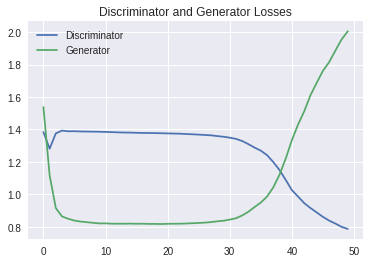

In [40]:
# Plot losses
plt.plot(d_losses, label = 'Discriminator')
plt.plot(g_losses, label = 'Generator')
plt.title('Discriminator and Generator Losses')
plt.legend();

## Generate Faces
After training, we can use the generator for generating new images.

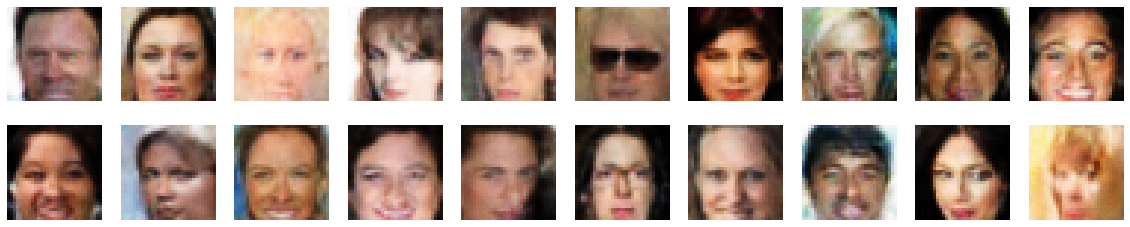

In [46]:
# Generate latent vector
num_images = 20
z = random_latent_vector(num_images, z_size)

# Generate faces
generated_images = G(z)

# Display
images = (generated_images.detach().cpu() + 1) / 2
display_images(images, num_images)

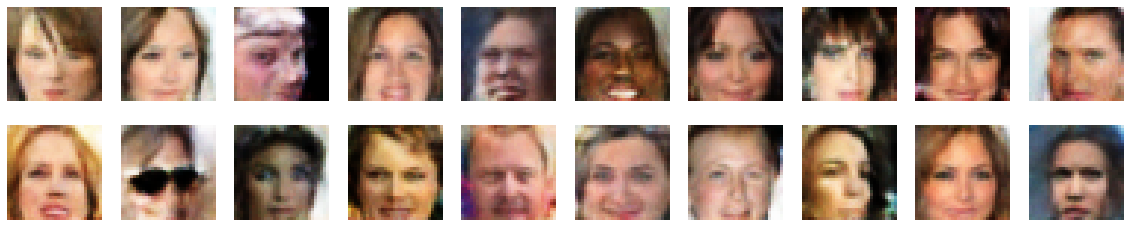

In [53]:
# Generate latent vector
num_images = 20
z = random_latent_vector(num_images, z_size)

# Generate faces
generated_images = G(z)

# Display
images = (generated_images.detach().cpu() + 1) / 2
display_images(images, num_images)